In [245]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import oemof.graph as graph
from oemof.tools import economics

import pyomo.environ as po
import numpy as np

solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [246]:
color_dict ={
             'coal': '#755d5d',
             'gas': '#c76c56',
             'oil': '#494a19',
             'lignite': '#56201d',
             'wind': '#4ca7c3',
             'pv': '#ffde32',
             'excess_el': '#9a9da1',
             'pp_coal': '#755d5d',
             'pp_gas': '#c76c56',
             'pp_chp': '#eeac7e',
             'b_heat_source': '#cd3333',
             'heat_source': '#cd3333',
             'heat_pump': '#42c77a',
             'electricity': '#0079ff',
             'demand_el': '#0079ff',
             'shortage_el': '#ff2626',
             'excess_el': '#ff2626',
             'biomass': '#01b42e',
             'pp_biomass': '#01b42e'}

In [247]:
def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=24*10, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=",")
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], nominal_value=66.3, fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], nominal_value=65.3, fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=200)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=85, actual_value=data['demand_el'], fixed=True)}))
    
    return bcoal, bgas, bel, energysystem

In [252]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.5}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

# create the model
optimization_model = Model(energysystem)

# add specific emission values to flow objects if source is a commodity bus
for s, t in optimization_model.flows.keys():
    if s is bgas:
        optimization_model.flows[s, t].emission_factor = 1  # t/MWh
    if s is bcoal:
        optimization_model.flows[s, t].emission_factor = 1  # t/MWh
emission_limit = 600

# add the outflow share
optimization_model.flows[(bgas, pp_gas)].outflow_share = [1] * 240

# Add a new pyomo Block
myblock = po.Block()

# pyomo does not need a po.Set, we can use a simple list as well
myblock.COMMODITYFLOWS = [k for (k, v) in optimization_model.flows.items()
                          if hasattr(v, 'emission_factor')]

# add the sub-model to the oemof Model instance
optimization_model.add_component('MyBlock', myblock)

# add emission constraint
myblock.emission_constr = po.Constraint(expr=(
        sum(optimization_model.flow[i, o, t]
            * optimization_model.flows[i, o].emission_factor
            for (i, o) in myblock.COMMODITYFLOWS
            for t in optimization_model.TIMESTEPS) <= emission_limit))

# add piecewise linear constraint

# create block
a = 0.9
mblock = po.Block()
mblock.c = po.Var()
mblock.x = po.Var(bounds=(min_x, max_x))
mblock.y = po.Var()

mblock.pw = po.Piecewise(mblock.y,
                 mblock.x,
                 pw_repn=pw_repn,
                 pw_constr_type='EQ',
                 pw_pts=[min_x, 0, 1, max_x],
                 f_rule=lambda m, x: pw(x))

mblock.constr1 = po.Constraint(expr=mblock.x == a)
mblock.constr2 = po.Constraint(expr=mblock.c == 23)


optimization_model.add_component('mblock', mblock)



In [253]:
# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

c = value(mblock.c)
x = value(mblock.x)
y = value(mblock.y)

print(c, x, y)
# results = outputlib.processing.results(optimization_model)
# string_results = outputlib.processing.convert_keys_to_strings(results)

# [(k[0], v['sequences'].sum()) for k, v in string_results.items() if (k[0]=='gas') or (k[0]=='coal')]

23 0.9 0.9


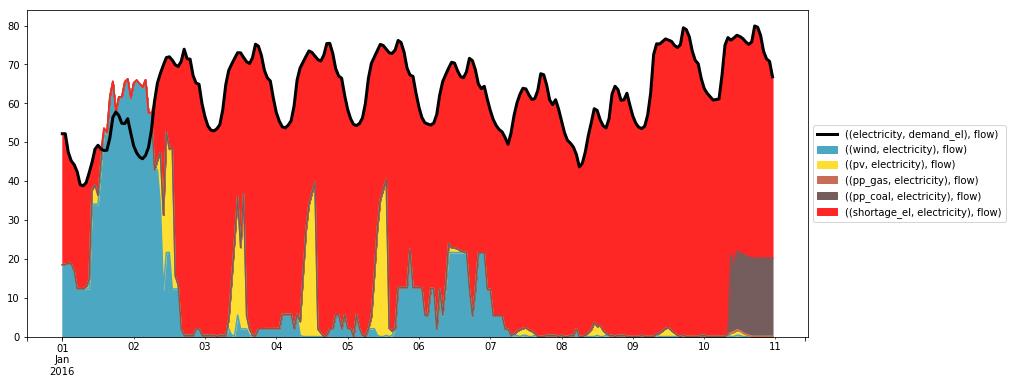

In [143]:
results_el = outputlib.views.node(results, 'electricity')

el_sequences = results_el['sequences']
el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                        (('pv', 'electricity'), 'flow'),
                        (('pp_gas', 'electricity'), 'flow'),
                        (('pp_coal', 'electricity'), 'flow'),
                        (('shortage_el', 'electricity'), 'flow')]]

fig, ax = plt.subplots(figsize=(14, 6))
for key in el_sequences.keys():
    color_dict[key] = color_dict[key[0][0]]
c=[color_dict.get(x, '#333333') for x in el_prod.columns]
el_prod.plot.area(ax=ax, color=c)
el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Notes
* wrong results using piecewise constraints issue: https://github.com/Pyomo/pyomo/issues/216#
* https://pyomo.readthedocs.io/en/latest/library_reference/kernel/syntax_comparison.html
* simons PR on sos2-costs https://github.com/oemof/oemof/pull/403/files
* Bryn's paper on piecewise constraints https://www.researchgate.net/publication/319334427_Applying_Piecewise_Linear_Characteristic_Curves_in_District_Energy_Optimisation
* pyomo examples https://github.com/Pyomo/pyomo/tree/master/examples/pyomo/piecewise

# Examples in pyomo

In [254]:
import pyomo.environ as po
import pyomo.core

def f(model,t1,t2,x):
    return 0.1*x - np.cos(5.0*x)


model = po.ConcreteModel()

# Note we can use an arbitrary number of index sets of 
# arbitrary dimension as the first arguments to the
# Piecewise component.
model.INDEX1 = po.Set(dimen=2, initialize=[(0,1),(8,3)])
model.X = po.Var(model.INDEX1, bounds=(-2,2))
model.Z = po.Var(model.INDEX1)
model.ZZ = po.Var()

# For indexed variables, pw_pts must be a
# python dictionary with keys the same as the variable index
PW_PTS = {}

# Increase n to see the solution approach:
# Z[i]=1.19, X[i]=1.89, obj=7.13
n = 3
# Using piecewise representations with a logarithmic number of
# binary variables ('LOG', 'DLOG') requires that pw_pts lists
# must have 2^n + 1 breakpoints.
num_points = 1 + 2**n
step = (2.0 - (-2.0))/(num_points-1)
for idx in model.X.index_set():
    PW_PTS[idx] = [-2.0 + i*step for i in range(num_points)]   # [-2.0, ..., 2.0]

model.linearized_constraint = Piecewise(model.INDEX1,        # indexing sets
                                        model.Z,model.X,     # range and domain variables
                                        pw_pts=PW_PTS,
                                        pw_constr_type='EQ',
                                        pw_repn='LOG',
                                        f_rule=f,
                                        force_pw=True)

model.constr = Constraint(expr=model.ZZ == 23)

# maximize the sum of Z over its index
# This is just a simple example of how to implement indexed variables. All indices
# of Z will have the same solution.
model.obj = Objective(expr= model.ZZ)
solver = SolverFactory('cbc')
results = solver.solve(model, keepfiles=False, tee=False)
results

{'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])], 'Solver': [{'Time': 0.03897738456726074, 'User time': -1.0, 'Status': 'ok', 'Termination condition': 'optimal', 'Error rc': 0}], 'Problem': [{'Number of objectives': 1, 'Number of nonzeros': 110, 'Number of constraints': 20, 'Name': 'tmpnel1ua2h.pyomo', 'Number of variables': 30, 'Upper bound': 23.0, 'Sense': 'minimize', 'Lower bound': 23.0}]}

In [216]:
x = [0.0, 1.5, 3.0, 5.0]
y = [1.1, -1.1, 2.0, 1.1]

model = ConcreteModel()
model.x = Var(bounds=(min(x), max(x)))
model.y = Var()

model.fx = Piecewise(model.y, model.x,
                     pw_repn='CC',
                     pw_pts=x,
                     pw_constr_type='EQ',
                     f_rule=y)

model.o = Objective(expr=model.y)
solver = SolverFactory('cbc')
results = solver.solve(model, keepfiles=False, tee=False)
results

{'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])], 'Solver': [{'Time': 0.03659319877624512, 'User time': -1.0, 'Status': 'ok', 'Termination condition': 'optimal', 'Error rc': 0}], 'Problem': [{'Number of objectives': 1, 'Number of nonzeros': 27, 'Number of constraints': 9, 'Name': 'tmp7110nve8.pyomo', 'Number of variables': 10, 'Upper bound': -1.1, 'Sense': 'minimize', 'Lower bound': -1.1}]}

In [242]:
pw_repn = 'CC'
a = 0.2
solver_name = 'cbc'

# create model
min_x, max_x = -10, 10
m = ConcreteModel()

mblock = po.Block()
mblock.c = Var()
mblock.x = Var(bounds=(min_x, max_x))
mblock.y = Var()

mblock.pw = Piecewise(mblock.y,
                 mblock.x,
                 pw_repn=pw_repn,
                 pw_constr_type='EQ',
                 pw_pts=[min_x, 0, 1, max_x],
                 f_rule=lambda m, x: pw(x))

mblock.constr1 = Constraint(expr=mblock.x == a)
mblock.constr2 = Constraint(expr=mblock.c == 23)

mblock.o = Objective(expr=mblock.c)

m.add_component('MyBlock', mblock)

# solve
solver = SolverFactory(solver_name)
results = solver.solve(m, keepfiles=False, tee=False)
c = value(mblock.c)
x = value(mblock.x)
y = value(mblock.y)

print(c, x, y)

23 0.2 0.2
